## Imports and Setup

In [1]:
import os
import pandas as pd
import geopandas as gpd
import logging
import joblib
import torch

import sys
sys.path.insert(0, "../utils/")
import post_utils
import eval_utils
import config_utils
from calib_utils import ECELoss

import matplotlib.pyplot as plt
import numpy as np

from sklearn.calibration import calibration_curve, CalibrationDisplay

%load_ext autoreload
%autoreload 2

## Load Config Files

In [88]:
iso_code = "RWA"
cwd = os.path.dirname(os.getcwd())
data_config_file = os.path.join(cwd, "configs/data_configs/data_config_ISO_AF.yaml")
data_config = config_utils.load_config(data_config_file)

#model_config_file = os.path.join(cwd, "configs/cnn_configs/vgg16_v01.yaml")
#model_config_file = os.path.join(cwd, "configs/cnn_configs/resnet50_v01.yaml")
model_config_file = os.path.join(cwd, "configs/cnn_configs/convnext_base_v01.yaml")
#model_config_file = os.path.join(cwd, "configs/cnn_configs/satlas-aerial_swinb_mi_01.yaml")
model_config = config_utils.load_config(model_config_file)

## Load Validation Results

In [89]:
val_output = post_utils.get_results(iso_code, model_config, phase="val")
val_output_tempscaling = post_utils.get_results(
    iso_code, model_config, phase="val", calibration="tempscaling"
)
val_output_isoreg = post_utils.get_results(
    iso_code, model_config, phase="val", calibration="isoreg"
)
val_output.head(3)

,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry,y_true,y_preds,y_probs
0,OSM-RWA-SCHOOL-00000025,OSM,RWA,Rwanda,Africa,Sub-Saharan Africa,école agriculture de Kisaro,NaN,0,0.0,school,21,urban,val,POINT (3008568.6199381975 -201322.90122067955),1,1,0.810888
1,OSM-RWA-SCHOOL-00000031,OSM,RWA,Rwanda,Africa,Sub-Saharan Africa,Kabarondo Vision Junior School,NaN,0,0.0,school,23,urban,val,POINT (3061915.279989045 -250593.40231574982),1,0,0.251067
2,OSM-RWA-SCHOOL-00000038,OSM,RWA,Rwanda,Africa,Sub-Saharan Africa,Nyundo School,NaN,0,0.0,school,21,urban,val,POINT (2981554.303206727 -272386.17445200746),1,1,0.952639


## Load Test Results

In [90]:
test_output = post_utils.get_results(iso_code, model_config, phase="test")
test_output_tempscaling = post_utils.get_results(
    iso_code, model_config, phase="test", calibration="tempscaling"
)
test_output_isoreg = post_utils.get_results(
    iso_code, model_config, phase="test", calibration="isoreg"
)
test_output.head(3)

,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry,y_true,y_preds,y_probs
0,OSM-RWA-SCHOOL-00000024,OSM,RWA,Rwanda,Africa,Sub-Saharan Africa,Sunrise Highschool,NaN,0,0.0,school,30,urban,test,POINT (2971279.9916823814 -184359.87557899157),1,1,0.952492
1,OSM-RWA-SCHOOL-00000026,OSM,RWA,Rwanda,Africa,Sub-Saharan Africa,Groupe Scolaire Musasa,NaN,0,0.0,school,21,urban,test,POINT (2982288.4183769096 -184721.98430914563),1,1,0.950518
2,OSM-RWA-SCHOOL-00000047,OSM,RWA,Rwanda,Africa,Sub-Saharan Africa,GR La Kermesse,NaN,0,0.0,school,30,urban,test,POINT (3017698.98915671 -242007.51373294732),1,1,0.940705


## Run Evaluation

In [91]:
val_results = post_utils.get_evaluation(val_output, beta=2, optim_threshold=None)
val_results_tempscaling = post_utils.get_evaluation(
    val_output_tempscaling, beta=2, optim_threshold=None
)
val_results_isoreg = post_utils.get_evaluation(
    val_output_isoreg, beta=2, optim_threshold=None
)
print(f"Brier score: {val_results['brier_score']:.4f}") 
print(f"Brier score temp scaling: {val_results_tempscaling['brier_score']:.4f}")
print(f"Brier score isotonic reg: {val_results_isoreg['brier_score']:.4f}")
for key, value in val_results_isoreg.items():
    if 'optim' in key: print(f"{key}: {value:.4f}")

Brier score: 0.0329
Brier score temp scaling: 0.0351
Brier score isotonic reg: 0.0295
optim_threshold: 0.1065
fbeta_score_optim: 94.8877
precision_score_optim: 90.4059
recall_score_optim: 96.0784
f1_score_optim: 93.1559
overall_accuracy_optim: 95.1087
balanced_accuracy_optim: 95.3365


In [92]:
test_results = post_utils.get_evaluation(
    test_output, 
    beta=2, 
    optim_threshold=val_results['optim_threshold']
)
test_results_tempscaling = post_utils.get_evaluation(
    test_output_tempscaling, 
    beta=2, 
    optim_threshold=val_results_tempscaling['optim_threshold']
)
test_results_isoreg= post_utils.get_evaluation(
    test_output_isoreg, 
    beta=2, 
    optim_threshold=val_results_isoreg['optim_threshold']
)
print(f"Brier score: {test_results['brier_score']:.4f}") 
print(f"Brier score temp scaling: {test_results_tempscaling['brier_score']:.4f}")
print(f"Brier score isotonic reg: {test_results_isoreg['brier_score']:.4f}")
for key, value in test_results_calibrated.items():
    if 'optim' in key: print(f"{key}: {value:.4f}")

Brier score: 0.0312
Brier score temp scaling: 0.0316
Brier score isotonic reg: 0.0316
optim_threshold: 0.2815
fbeta_score_optim: 94.7926
precision_score_optim: 89.0190
recall_score_optim: 96.3550
f1_score_optim: 92.5419
overall_accuracy_optim: 94.8093
balanced_accuracy_optim: 95.1942


## Model Calibration

### Validation Set Calibration

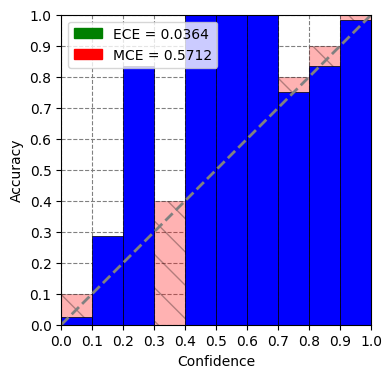

In [93]:
ece = ECELoss(n_bins=10)
ece.draw_reliability_graph(
    val_output["y_probs"].values, 
    val_output["y_true"].values
)

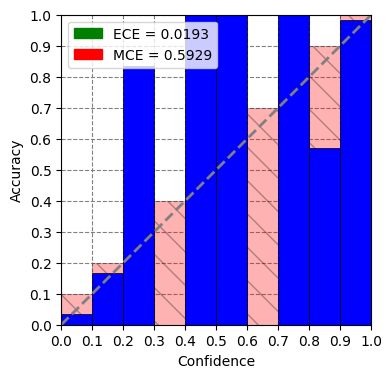

In [94]:
ece.draw_reliability_graph(
    val_output_tempscaling["y_probs"], 
    val_output["y_true"].values
)

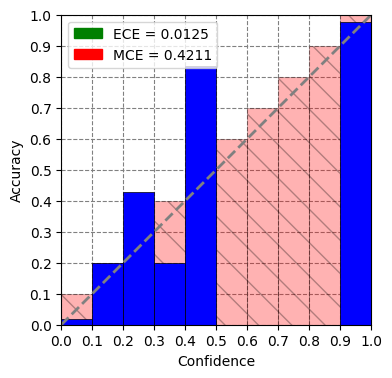

In [95]:
ece.draw_reliability_graph(
    val_output_isoreg["y_probs"], 
    val_output["y_true"].values
)

### Test Set Calibration

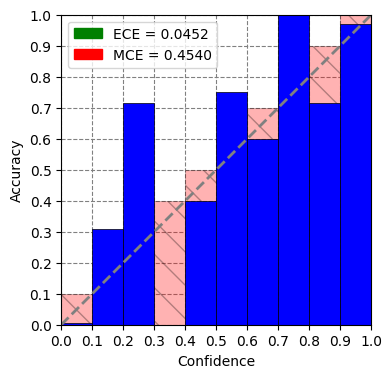

In [96]:
ece.draw_reliability_graph(
    test_output["y_probs"].values, 
    test_output["y_true"].values
)

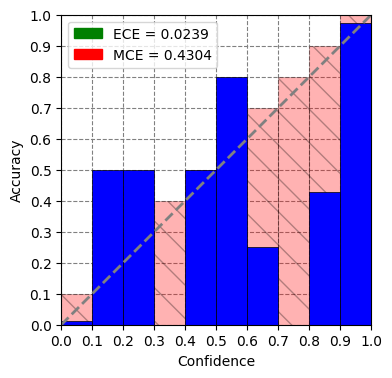

In [97]:
ece.draw_reliability_graph(
    test_output_tempscaling["y_probs"], 
    test_output["y_true"].values
)

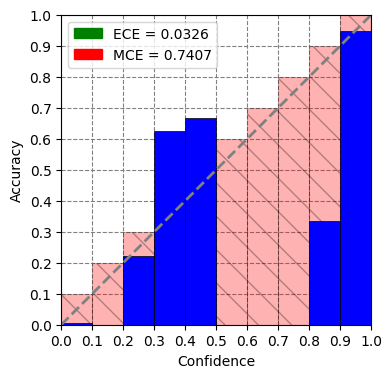

In [98]:
ece.draw_reliability_graph(
    test_output_isoreg["y_probs"], 
    test_output["y_true"].values
)

## Plot Results

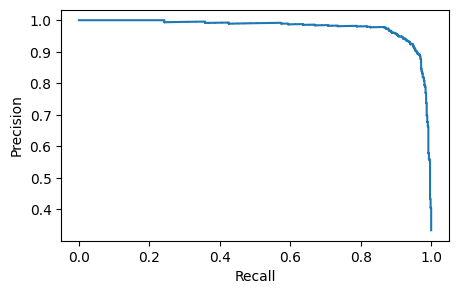

In [41]:
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
disp = PrecisionRecallDisplay(
    precision=test_results['precision_scores_'], 
    recall=test_results['recall_scores_']
)
disp.plot(ax=ax);

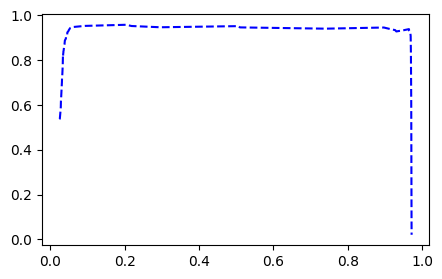

In [17]:
_, test_fscores = eval_utils.get_optimal_threshold(
    test_results['precision_scores_'], 
    test_results['recall_scores_'], 
    test_results['thresholds_'], 
    beta=1
)
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(test_thresholds, test_fscores[:-1], "b--");

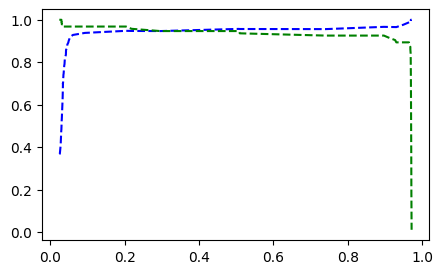

In [19]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(
    test_results['thresholds_'], 
    test_results['precision_scores_'][:-1], 
    "b--"
)
ax.plot(
    test_results['thresholds_'], 
    test_results['recall_scores_'][:-1], 
    "g--"
);